In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

# LOAD A LC

In [9]:
fold_ver = 0

#save_dir = '/home/hwei/sigma_clipping_out'
#norm_dir = '/home/hwei/class_rv_lc/hsp_lcs_validation'
norm_dir = '/home/hwei/search_kics' # THIS IS WHERE YOU WANT TO LOAD UR NORM FILES

#true_norm_dir = '/home/hwei/class_rv_lc/usp_lcs'
true_norm_dir = norm_dir

In [58]:
# Test individual target

#i = 1013

#kid = df['kepid'].iloc[i]
kid = 7434875
print (kid)

#indices, lcf = load_folds(kid, save_dir, fold_ver, 128)
#lcf
#bin_counts = load_bin_counts(kid, save_dir, fold_ver)

7434875


In [59]:
##norm_data = np.load(os.path.join(norm_dir, str(kid) + '.npz'))
#norm_data

dir_list = os.listdir(true_norm_dir)
all_files = []
time = []
flux = []
origin = []
note1 = []
transit_ids = []
file = ''
for f in dir_list:
    if str(kid) in f:
        print(f)
        file = f
        break
if file == '':
    print("NO FILE FOUND")
norm_data = np.load(true_norm_dir + '/' + file)
norm_data

#IT PRINTS NAME OF FILE IF IT FOUND A NORM FILE, OTHERWISE IT PRINTS NO FILE FOUND

KIC7434875_long_v1.npz


In [60]:
norm_data.files
time_old = norm_data['time']
flux_old = norm_data['flux']
transit_idx = norm_data['transit_ids']
print(norm_data['origin'])
time_norm = time_old[~transit_idx]
flux_norm = flux_old[~transit_idx]

hwei


# PLOT BLS AND TRANSIT LOCATION

In [61]:
def plot_transits_v0(t0_bkjd, period_day, duration_day, time_bkjd, flux):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
   
    #time_bkjd = np.array(lc.astropy_time.value)
    
#     if time_bkjd[0] > 2400000.5:
        
#         time_bkjd = time_bkjd - 2400000.5
   
    #flux = lc.flux
   
    t0f_bkjd = np.copy(t0_bkjd)
   
    tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day, time_bkjd, flux)
   
    # For each tranist find all datapoints within the tranist duration window
   
    ntot_idx = np.ones(len(flux), dtype=bool)
    plt.figure(figsize=(20,12))
    for tot in tots_bkjd:
       
        tot_idx = (time_bkjd > tot - duration_day / 2) & (time_bkjd < tot + duration_day / 2)
       
        ntot_idx = ntot_idx & ~tot_idx
        
        plt.axvline(tot, c='r')
    plt.plot(time_bkjd[ntot_idx], flux[ntot_idx], '.k')
    plt.plot(time_bkjd[~ntot_idx], flux[~ntot_idx], '.r')
    
    plt.xlabel('time [day]')
    plt.ylabel('flux [ppt]');
    plt.show(block=0)
def get_transit_times(t0_bkjd, period_day, duration_day, time_bkjd, flux):
    
    t0f_bkjd = np.copy(t0_bkjd)
   
    while t0f_bkjd > time_bkjd[0]:
       
        t0f_bkjd -= period_day
        
    #t0f_bkjd += period_day
        
    while t0f_bkjd < time_bkjd[0]:
       
        t0f_bkjd += period_day
        
    #t0f_bkjd -= period_day
       
    return np.arange(t0f_bkjd, time_bkjd.max(), step=period_day)
    

In [62]:
# The box least squares (BLS) function definition

def get_per(t, f, per_bounds=[1, 100], zoom_time_wdith=1.0, num_folds = 100000):
    
    # Use box least squares (BLS) method to find the period and t0 for the transit
    
    gi = np.isfinite(t + f)
    
    t = t[gi]
    f = f[gi]
    
    
    # https://exoplanet.dfm.io/en/stable/tutorials/together/

    from astropy.timeseries import BoxLeastSquares

    m = np.zeros(len(t), dtype=bool)
    period_grid = np.exp(np.linspace(np.log(per_bounds[0]), np.log(per_bounds[1]), num_folds))
    bls_results = []
    periods = []
    t0s = []
    depths = []

    # Compute the periodogram for each planet by iteratively masking out
    # transits from the higher signal to noise planets. Here we're assuming
    # that we know that there are exactly two planets.
    for i in range(1):
        bls = BoxLeastSquares(t[~m], f[~m])
        bls_power = bls.power(period_grid, 0.1, oversample=20)
        bls_results.append(bls_power)

        # Save the highest peak as the planet candidate
        index = np.argmax(bls_power.power)
        periods.append(bls_power.period[index])
        t0s.append(bls_power.transit_time[index])
        depths.append(bls_power.depth[index])

        # Mask the data points that are in transit for this candidate
        #m |= bls.transit_mask(t, periods[-1], 0.5, t0s[-1])
        
        
        
    fig, axes = plt.subplots(len(bls_results), 2, figsize=(10, 5))

    for i in range(len(bls_results)):
        # Plot the periodogram
        if len(bls_results) > 1:
            ax = axes[i, 0]
        else:
            ax = axes[0]
        ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
        ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
        ax.annotate(
            "period = {0:.4f} d".format(periods[i]),
            (0, 1),
            xycoords="axes fraction",
            xytext=(5, -5),
            textcoords="offset points",
            va="top",
            ha="left",
            fontsize=12,
        )
        ax.set_ylabel("bls power")
        ax.set_yticks([])
        ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
        if i < len(bls_results) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("log10(period)")

        # Plot the folded transit
        if len(bls_results) > 1:
            ax = axes[i, 1]
        else:
            ax = axes[1]
        p = periods[i]
        x_fold = (t - t0s[i] + 0.5 * p) % p - 0.5 * p
        m = np.abs(x_fold) < zoom_time_wdith
        ax.plot(x_fold[m], f[m], ".k")

        # Overplot the phase binned light curve
        bins = np.linspace(-zoom_time_wdith, zoom_time_wdith, np.int64(32/0.4*zoom_time_wdith))
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=f)
        denom[num == 0] = 1.0
        ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

        ax.set_xlim(-zoom_time_wdith, zoom_time_wdith)
        ax.set_ylabel("relative flux [ppt]")
        if i < len(bls_results) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("time since transit")

    fig.subplots_adjust(hspace=0.02)
    
    return periods[0], t0s[0]

# Use box least squares (BLS) method to find the period and t0 for the transit

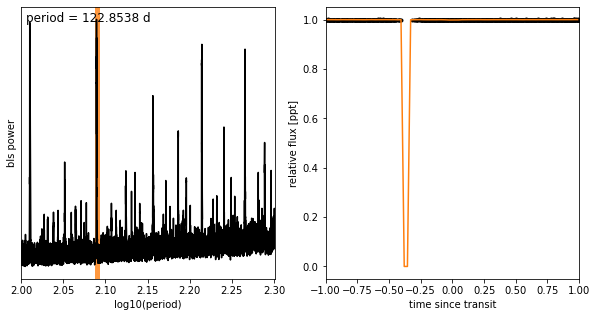

In [63]:
p, t0 = get_per(time_norm, flux_norm, 
                per_bounds=[100, 200], # Give a lower and upper bound period for the transit search
                zoom_time_wdith=1.0, num_folds = 100000   # Days shown to the left and right of the transit in the left subplot
               )

7434875


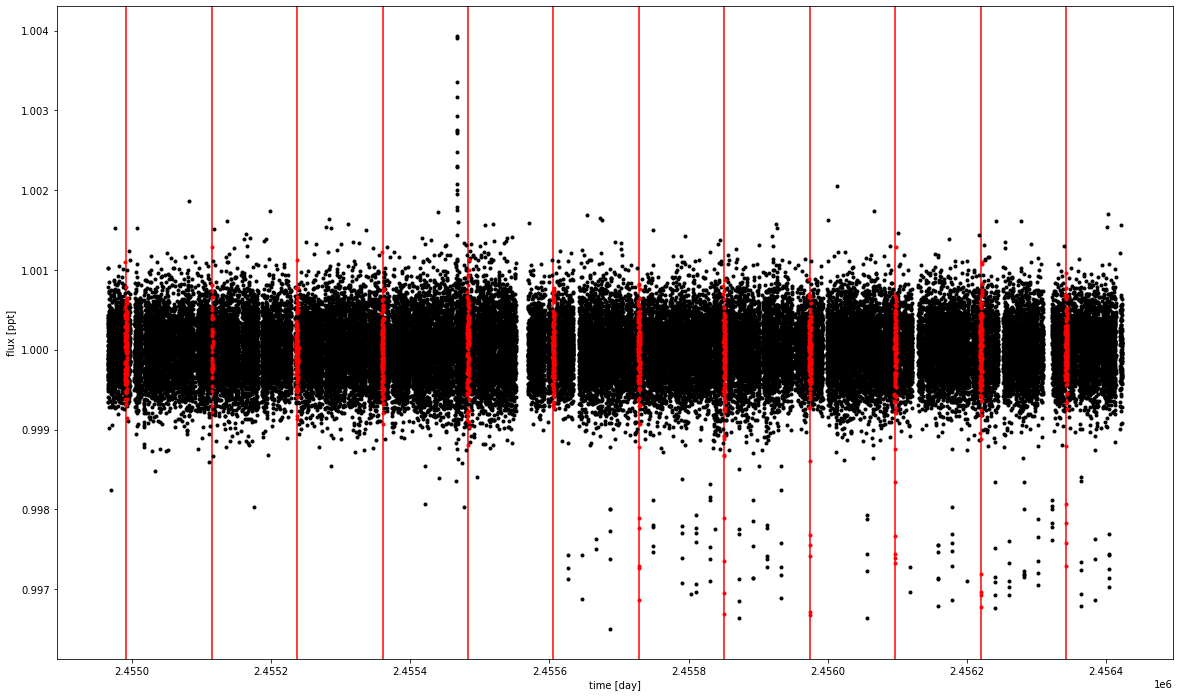

In [64]:
print(kid)
plot_transits_v0(np.array([t0]), np.array([p]), np.array([3.]), time_norm, flux_norm)

In [65]:
p

122.8538414650868

In [66]:
t0

2454991.621445668

# GET ALL CONFIRMED CANDIDATES FOR THE KIC

In [68]:
#IMPORT KEPLER TABLES, THIS IS THE KEPLER XLSX FILE

import pandas as pd
kepler_catalog_dir = '/home/hwei/class_rv_lc/KeplerCumulative2.xlsx' 
table = pd.read_excel(kepler_catalog_dir)
table

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_period,koi_time0,koi_duration
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,9.488036,2455003.539,2.95750
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,54.418383,2454995.514,4.50700
2,3,10811496,K00753.01,NaN,CANDIDATE,19.899140,2455008.850,1.78220
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,1.736952,2455003.308,2.40641
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,2.525592,2455004.596,1.65450
...,...,...,...,...,...,...,...,...
9559,9560,10090151,K07985.01,NaN,FALSE POSITIVE,0.527699,2454964.705,3.22210
9560,9561,10128825,K07986.01,NaN,CANDIDATE,1.739849,2454966.001,3.11400
9561,9562,10147276,K07987.01,NaN,FALSE POSITIVE,0.681402,2454965.182,0.86500
9562,9563,10155286,K07988.01,NaN,CANDIDATE,333.486169,2454986.615,3.19900


In [69]:
#koi_list = kepid_search_arr['KOIGOOD'][0:28]
kepler_kics = table['kepid'][:]
kepler_kois = [float(e[1:]) for e in table['kepoi_name']]
kepler_t0_bjd = table['koi_time0'][:]
kepler_period_day = table['koi_period'][:]
kepler_duration_day = table['koi_duration'][:]/24.

In [71]:
#CHANGE X TO SPECIFY KIC INDEX IN LIST

all_t0_bkjd = []
all_period_day = []
all_duration_day = []
interest_idx = - 1


#I just did this for USP catalog only, you can modify it for other catalogs as well

#x= 5

#target_name = kepid_list[x] #Must be an KIC integer
target_name = kid
#print("TARGET NUMBER: " + str(x))
print("TARGET KEPID: " + str(target_name))

print("\nList of Planets in System:")
for i in range(len(kepler_kics)):
    if (kepler_kics[i] == target_name):
        print(kepler_kois[i])
        all_t0_bkjd.append(kepler_t0_bjd[i])
        all_period_day.append(kepler_period_day[i])
        all_duration_day.append(kepler_duration_day[i])
        
#all_t0_bkjd.append(19.)
#all_period_day.append(185.3307)
#all_duration_day.append(3.0)
interest_idx = 1

print("\nALL T0s:")
print(all_t0_bkjd)
print("ALL Periods")
print(all_period_day)
print("ALL Duration")
print(all_duration_day)
print("Interest ID")
print(interest_idx)

#fig_dir = os.path.join(normalized_plot_dir, str(target_name))
#mkdir(fig_dir)
#dir_contains(target_name)

TARGET KEPID: 7434875

List of Planets in System:
884.01
884.02
884.03

ALL T0s:
[2455010.186, 2455011.668, 2454968.316]
ALL Periods
[9.439459486, 20.47748843, 3.336123113]
ALL Duration
[0.12074583333333333, 0.11818333333333332, 0.08173333333333334]
Interest ID
1


In [72]:
p / np.array(all_period_day)

array([13.01492333,  5.99945847, 36.82533207])